In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))

import os
import gc
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import Bbox
from matplotlib.patches import FancyBboxPatch
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

from functions.mandyocIO import read_mandyoc_output, read_datasets, read_particle_path, plot_data

# Initial setup

In [2]:
path = os.getcwd().split('/') # Get local file
machine_path = '/'+path[1]+'/'+path[2] # Select home according to OS.

# Path to the model directory
# model_path = machine_path + "/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT200_rheol19_c1250_C1_HprodAst"
model_path = machine_path + "/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/DT200_PT1291oC/Sim001_rheol19_acc_DT200_PT1291oC_TBC_mean"

read_ascii = True # if False, it will skip the ascii reading and saving processes and it will read the datasets from previous runs
save_images = True # Generate and save all the possible images
save_big_dataset = True

# Datasets handeling
## Model path

In [3]:
# Create the output directory to save the dataset
output_path = os.path.join(model_path, "_output")
if not os.path.isdir(output_path):
    os.makedirs(output_path)

model_name = os.path.split(model_path)[1]

datasets = (#Properties from mandyoc. Comment/uncomment to select properties of the dataset
            'density',
            'radiogenic_heat',
            'pressure',
            'strain',
            'strain_rate',### Read ascii outputs and save them as xarray.Datasets,
            'surface',
            'temperature',
            'viscosity'
            )

### Read ascii outputs and save them as xarray.Datasets

In [4]:
# Read data and convert them to xarray.Dataset
if (read_ascii):
    ds_data = read_mandyoc_output(
        model_path,
        datasets=datasets,
        parameters_file="param.txt"
    )

if (save_big_dataset):
    dataset = read_datasets(model_path, datasets, save_big_dataset = True)

    # Normalize velocity values
    if ("velocity_x" and "velocity_z") in dataset.data_vars:
        v_max = np.max((dataset.velocity_x**2 + dataset.velocity_z**2)**(0.5))    
        dataset.velocity_x[:] = dataset.velocity_x[:] / v_max
        dataset.velocity_z[:] = dataset.velocity_z[:] / v_max
        
#     print(dataset)

Starting...
Reading temperature files... Temperature files read. Temperature files saved.
Reading density files... Density files read. Density files saved.
Reading radiogenic_heat files... Radiogenic_heat files read. Radiogenic_heat files saved.
Reading viscosity files... Viscosity files read. Viscosity files saved.
Reading strain files... Strain files read. Strain files saved.
Reading strain_rate files... Strain_rate files read. Strain_rate files saved.
Reading pressure files... Pressure files read. Pressure files saved.
Reading surface files... Surface files read. Surface files saved.
All files read and saved.
Saving dataset with all Mandyoc data
Big dataset file saved.


Time: 0.0; Step: 0
Property: lithology


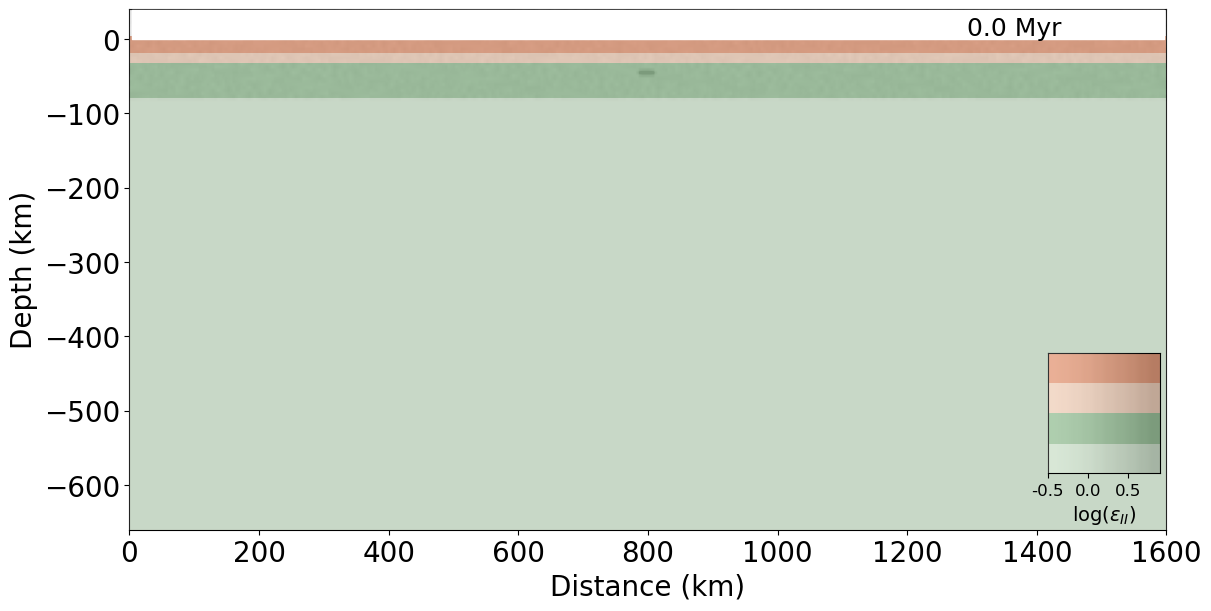

In [7]:
properties = [#Properties from mandyoc. Comment/uncomment to select with ones you would like to plot
#              'density',
#              'radiogenic_heat',
             'lithology',
#              'pressure',
#              'strain',
#              'strain_rate',
#              'temperature',
#              'temperature_anomaly',
#              'surface',
#              'viscosity',
#              'vs_anomaly'
             ]

t0 = dataset.time[0]
t1 = dataset.time[1]
dt = int(t1 - t0)

# start = int(t0)
# end = int(dataset.time.size - 1)
# step = 1

start = 0
end = 1
step = 1

# step_initial = dataset.step[0]
# step_1 = dataset.step[1]
# step_final = dataset.step[-1]
# dstep = int(step_1 - step_initial)

for i in range(start, end, step):
    data = dataset.isel(time=i)
    print(f"Time: {np.round(float(data.time), 2)}; Step: {int(data.step)}")
    for prop in properties:
        print(f"Property: {prop}")
        if(prop != 'surface'): # you can customize
            xlims = [0, float(data.lx) / 1.0e3]
            ylims = [-float(data.lz) / 1.0e3 + 40, 40]
        else:
            xmin = 0 #+ 200
            xmax = float(data.lx) / 1.0E3 #- 200
            xlims = [xmin, xmax]
            ylims = [-7, 7]
            
        plot_data(data, prop, xlims, ylims, model_path, output_path)


# Making video

In [12]:
for prop in properties:
    
    line = f"ffmpeg -r 30 -f image2 -s 1920x1080 -pattern_type glob -i '{model_path}/_output/{model_name}_{prop}_*.png' -vcodec libx264 -crf 25 -pix_fmt yuv420p {model_path}/_output/{model_name}.mp4"
    print(line)

ffmpeg -r 30 -f image2 -s 1920x1080 -pattern_type glob -i '/home/joao_macedo/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/DT200_PT1291oC/Sim001_rheol19_acc_DT200_PT1291oC_TBC_mean/_output/Sim001_rheol19_acc_DT200_PT1291oC_TBC_mean_lithology_*.png' -vcodec libx264 -crf 25 -pix_fmt yuv420p /home/joao_macedo/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/DT200_PT1291oC/Sim001_rheol19_acc_DT200_PT1291oC_TBC_mean/_output/Sim001_rheol19_acc_DT200_PT1291oC_TBC_mean.mp4


# Function to plot data

In [55]:
def extract_interface(z, Z, Nx, Rhoi, rho):
    '''
    Extract interface from Rhoi according to a given density (rho)

    Parameters
    ----------
    z: numpy array
        Array representing z direction.

    Z: numpy array
        Array representing z direction resampled with higher resolution.

    Nx: int
        Number of points in x direction.

    Rhoi: numpy array (Nz, Nx)
        Density field from mandyoc

    rho: int
        Value of density to be searched in Rhoi field
        
    Returns
    -------
    topo_aux: numpy array
        Array containing the extacted interface.
    '''

    topo_aux = []
    
    for j in np.arange(Nx):
        topoi = interp1d(z, Rhoi[:,j]) #return a "function" of interpolation to apply in other array
        idx = (np.abs(topoi(Z)-rho)).argmin()
        topo = Z[idx]
        topo_aux = np.append(topo_aux, topo)

    return topo_aux

def log_fmt(x, pos):
    return "{:.0f}".format(np.log10(x))
    
def plot_data(dataset, prop, xlims, ylims, model_path, output_path, save_frames=True):
    '''
    Plot and save data from mandyoc according to a given property and domain limits.

    Parameters
    ----------
    dataset: :class:`xarray.Dataset`
        Dataset containing mandyoc data for a single time step.
    
    prop: str
        Property from mandyoc.

    xlims: list
        List with the limits of x axis
        
    ylims: list
        List with the limits of y axis

    model_path: str
        Path to model

    output_path: str
        Path to save outputs
        
    save_frames: bool
        True to save frame by frames
        False to do not save the frames
    '''
    
    props_label = {'density':              r'$\mathrm{[kg/m^3]}$',
                   'radiogenic_heat':       'log(W/kg)',
                   'lithology':            r'log$(\epsilon_{II})$',
                   'pressure':              'P [GPa]',
                   'strain':               r'Accumulated strain [$\varepsilon$]',
                   'strain_rate':          r'log($\dot{\varepsilon}$)',
#                    'strain_rate':          r'$\dot{\varepsilon}$',
                   'temperature':          r'$^{\circ}\mathrm{[C]}$',
                   'temperature_anomaly':  r'Temperature anomaly $^{\circ}\mathrm{[C]}$',
                   'topography':            'Topography [km]',
                   'viscosity':             'log(Pa.s)'
                   }
    
    props_cmap = {'density': 'viridis',
                  'radiogenic_heat': 'inferno',
                  'lithology': 'viridis',
                  'pressure': 'viridis',
#                   'strain': 'viridis', #Default. Comment this line and uncomment one of the options bellow
#                   'strain': 'cividis',
#                   'strain': 'Greys',
                  'strain': 'inferno',
#                   'strain': 'magma',
                  'strain_rate': 'viridis',
                  'temperature': 'viridis',
                  'temperature_anomaly': 'RdBu_r',
                  'topography': '',
                  'viscosity': 'viridis'
                   }

    #limits of colorbars
    vals_minmax = {'density':             [0.0, 3378.],
                   'radiogenic_heat':     [1.0E-13, 1.0E-9],
                   'lithology':           [None, None],
                   'pressure':            [-1.0E-3, 1.0],
                   'strain':              [None, None],
                   'strain_rate':         [1.0E-19, 1.0E-14],
#                    'strain_rate':         [np.log10(1.0E-19), np.log10(1.0E-14)],
                   'temperature':         [0, 1600],
                   'temperature_anomaly': [-150, 150],
                   'surface':             [-6, 6],
                   'viscosity':           [1.0E18, 1.0E25],
#                    'viscosity':           [np.log10(1.0E18), np.log10(1.0E25)]
                  }
    Nx = int(dataset.nx)
    Nz = int(dataset.nz)
    Lx = float(dataset.lx)
    Lz = float(dataset.lz)
    instant = np.round(float(dataset.time), 2)
    
    xi = np.linspace(0, Lx/1000, Nx)
    zi = np.linspace(-Lz/1000+40, 0+40, Nz) #km, +40 to compensate the air layer above sea level
    xx, zz = np.meshgrid(xi, zi)
    
    #creating Canvas
    plt.close()
    label_size=20
    plt.rc('xtick', labelsize = label_size)
    plt.rc('ytick', labelsize = label_size)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 6), constrained_layout = True)
    #plot Time in Myr
    ax.text(0.8, 0.95, ' {:01} Myr'.format(instant), fontsize = 18, zorder=52, transform=ax.transAxes)
    
    val_minmax = vals_minmax[prop]
    
    #dealing with special data
    if(prop == 'lithology'):
        data = dataset['strain']
        
    elif(prop == 'temperature_anomaly'):
        #removing horizontal mean temperature
        A = dataset['temperature']
        B = A.T #shape: (Nz, Nx)
        C = np.mean(B, axis=1) #shape: 151==Nz
        D = (B.T - C) #B.T (Nx,Nz) para conseguir subtrair C
        data = D
        
    elif(prop == 'surface'):
        print('Dealing with data')
#         topo_from_density = True
        topo_from_density = False
        
        if(topo_from_density == True):
            Rhoi = dataset.density.T
            interfaces=[2900, 3365]
            ##Extract layer topography
            z = np.linspace(Lz/1000.0, 0, Nz)
            Z = np.linspace(Lz/1000.0, 0, 8001) #zi
            x = np.linspace(Lx/1000.0, 0, Nx)

            topo_interface = extract_interface(z, Z, Nx, Rhoi, 300.) #200 kg/m3 = air/crust interface
            
            condx = (xi >= 100) & (xi <= 600)
            z_mean = np.mean(topo_interface[condx])
            
            topo_interface -= np.abs(z_mean)
            topo_interface = -1.0*topo_interface

            data = topo_interface
        else:
            data = dataset.surface/1.0e3 + 40.0 #km + air layer correction
            
            
    elif(prop == 'pressure'):
        data = dataset[prop]/1.0E9 #GPa
        
    else:
        data = dataset[prop] 
        
    if(prop == 'strain_rate' or prop == 'radiogenic_heat' or prop == 'strain_rate' or prop == 'viscosity'): #properties that need a lognorm colorbar
        im = ax.imshow(data.T,
                       cmap = props_cmap[prop],
                       origin='lower',
                       extent = (0, Lx / 1.0E3, -Lz / 1.0E3 + 40, 0 + 40),
                       norm = LogNorm(vmin=val_minmax[0], vmax=val_minmax[1]),
#                        vmin=val_minmax[0], vmax=val_minmax[1],
                       aspect = 'auto')
        
        #creating colorbar
        axins1 = inset_axes(ax,
                            width="30%",  # width: 30% of parent_bbox width
                            height="5%",  # height: 5%
                            bbox_to_anchor=(-0.02, -0.82, 1, 1),
                            bbox_transform=ax.transAxes,
                            )

        clb = fig.colorbar(im,
                           cax=axins1,
#                            ticks=ticks,
                           orientation='horizontal',
                           fraction=0.08,
                           pad=0.2,
                           format=log_fmt)

        clb.set_label(props_label[prop], fontsize=12)
        clb.minorticks_off()
    
    elif (prop == 'density' or prop == 'pressure' or prop == 'temperature' or prop == 'temperature_anomaly'): #properties that need a regular colorbar
        im = ax.imshow(data.T,
                       cmap = props_cmap[prop],
                       origin='lower',
                       extent = (0, Lx / 1.0E3, -Lz / 1.0E3 + 40, 0 + 40),
                       vmin=val_minmax[0], vmax=val_minmax[1],
                       aspect = 'auto')
        
        axins1 = inset_axes(ax,
                            width="30%",  # width: 30% of parent_bbox width
                            height="5%",  # height: 5%
                            bbox_to_anchor=(-0.02, -0.82, 1, 1),
                            bbox_transform=ax.transAxes,
                            )
        
#         ticks = np.linspace(val_minmax[0], val_minmax[1], 6, endpoint=True)

        #precision of colorbar ticks
        if(prop == 'pressure'): 
            fmt = '%.2f'
        else:
            fmt = '%.0f'
            
        clb = fig.colorbar(im,
                           cax=axins1,
#                            ticks=ticks,
                           orientation='horizontal',
                           fraction=0.08,
                           pad=0.2,
                           format=fmt)

        clb.set_label(props_label[prop], fontsize=12)
        clb.minorticks_off()
        
    elif(prop == 'strain'):
        im = ax.imshow(data.T,
                       cmap = props_cmap[prop],
                       origin='lower',
                       extent = (0, Lx / 1.0E3, -Lz / 1.0E3 + 40, 0 + 40),
                       vmin = float(data.min()),
                       vmax = float(data.max()),
                       aspect = 'auto')
        
    elif(prop == 'surface'):
        ax.plot(dataset.x/1.0e3, data, alpha = 1, linewidth = 2.0, color = "blueviolet")
        
    elif(prop == 'lithology'): #shaded lithology plot
        cr = 255.
        color_uc = (228. / cr, 156. / cr, 124. / cr)
        color_lc = (240. / cr, 209. / cr, 188. / cr)
        color_lit = (155. / cr, 194. / cr, 155. / cr)
        color_ast = (207. / cr, 226. / cr, 205. / cr)
        
        Rhoi = dataset.density.T
        interfaces=[2900, 3365]
        
        ##Extract layer topography
        z = np.linspace(Lz/1000.0, 0, Nz)
        Z = np.linspace(Lz/1000.0, 0, 8001) #zi
        x = np.linspace(Lx/1000.0, 0, Nx)
            
        topo_interface = extract_interface(z, Z, Nx, Rhoi, 300.) #200 kg/m3 = air/crust interface
        condx = (xi >= 100) & (xi <= 600)
        z_mean = np.mean(topo_interface[condx])
        topo_interface -= np.abs(z_mean)
        topo_interface = -1.0*topo_interface
        
        ax.contourf(xx,
                    zz,
                    Rhoi,
                    levels = [200., 2750, 2900, 3365, 3900],
                    colors = [color_uc, color_lc, color_lit, color_ast])
        
        im=ax.imshow(data.T,
                     cmap = 'Greys',
                     origin = 'lower',
                     extent = (0, Lx / 1.0E3, -Lz / 1.0E3 + 40,0 + 40),
                     zorder = 50,
                     alpha = 0.2, vmin=-0.5,
                     vmax = 0.7,
                     aspect = 'auto')
        #legend box
        b1 = [0.84, #horizontal position
              0.22, #vertical position
              0.15, #horizontal sift
              0.20  #scale
             ]
        bv1 = plt.axes(b1)
        A = np.zeros((100, 10))

        A[:25, :] = 2700
        A[25:50, :] = 2800
        A[50:75, :] = 3300
        A[75:100, :] = 3400

        A = A[::-1, :]

        xA = np.linspace(-0.5, 0.9, 10)
        yA = np.linspace(0, 1.5, 100)

        xxA, yyA = np.meshgrid(xA, yA)
        air_threshold = 200
        plt.contourf(
            xxA,
            yyA,
            A,
            levels=[air_threshold, 2750, 2900, 3365, 3900],
            colors=[color_uc, color_lc, color_lit, color_ast],
        )

        plt.imshow(
            xxA[::-1, :],
            extent=[-0.5, 0.9, 0, 1.5],
            zorder=100,
            alpha=0.2,
            cmap=plt.get_cmap("Greys"),
            vmin=-0.5,
            vmax=0.9,
        )

        bv1.set_yticklabels([])
        plt.xlabel(r"log$(\varepsilon_{II})$", size=14)
        bv1.tick_params(axis='x', which='major', labelsize=12)
        bv1.set_xticks([-0.5, 0, 0.5])
        bv1.set_yticks([])
        bv1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            
    if(prop != 'surface'):
        #Filling above topographic surface
        Rhoi = dataset.density.T
        interfaces=[2900, 3365]
        ##Extract layer topography
        z = np.linspace(Lz/1000.0, 0, Nz)
        Z = np.linspace(Lz/1000.0, 0, 8001) #zi
        x = np.linspace(Lx/1000.0, 0, Nx)

        topo_interface = extract_interface(z, Z, Nx, Rhoi, 300.) #200 kg/m3 = air/crust interface
        condx = (xi >= 100) & (xi <= 600)
        z_mean = np.mean(topo_interface[condx])
        topo_interface -= np.abs(z_mean)
        topo_interface = -1.0*topo_interface

        xaux = xx[0]
        condaux = (xaux>xlims[0]) & (xaux<xlims[1])
        xaux = xaux[condaux]

        ax.fill_between(xaux, topo_interface[condaux], 39, color='white', alpha=1.0, zorder=51)
        
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_xlabel("Distance (km)", fontsize = label_size)
        ax.set_ylabel("Depth (km)", fontsize = label_size)
        
    else:
        ax.grid('-k', alpha=0.7)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_xlabel("Distance (km)", fontsize = label_size)
        ax.set_ylabel("Topography (km)", fontsize = label_size)
        
    if (save_frames == True):    
        fig_name = f"{output_path}/{model_name}_{prop}_{str(i).zfill(6)}.png"
        plt.savefig(fig_name, dpi=400)